spooky_author.png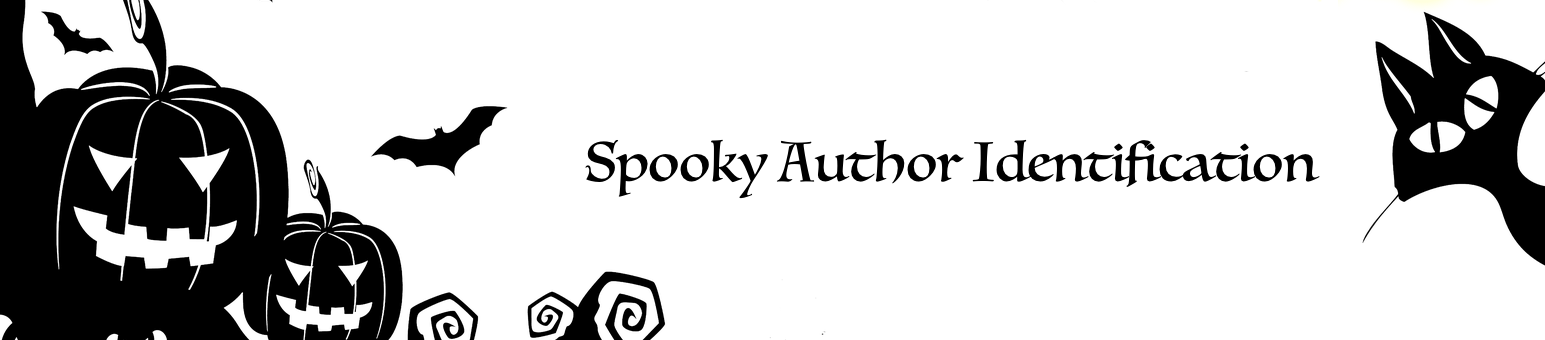

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

**File descriptions**

    train.csv - the training set
    test.csv - the test set
    sample_submission.csv - a sample submission file in the correct format

**Data fields**

    id - a unique identifier for each sentence
    text - some text written by one of the authors
    author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

### Data Exploration
We begin with looking into the data..

In [87]:
wr_dict = {'EAP': 'Edgar Allan Poe', 'HPL': 'HP Lovecraft', 'MWS': 'Mary Wollstonecraft Shelley'}
import json
from collections import Counter, defaultdict
import pandas as pd
import spacy
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time

sns.set_style("whitegrid")

from wordcloud import WordCloud, STOPWORDS  # https://github.com/amueller/word_cloud
from itertools import chain

In [88]:
DATA_DIR = '/Users/ik/Data/spook/'

In [89]:
train_data = pd.read_csv(DATA_DIR + 'train.csv', dtype=str)
test_data = pd.read_csv(DATA_DIR + 'test.csv', dtype=str)

In [90]:
Counter(train_data.author)

Counter({'EAP': 7900, 'HPL': 5635, 'MWS': 6044})

### Edgar Allan Poe
* The Cask of Amontillado - http://www.gutenberg.org/ebooks/1063.txt.utf-8

* The Fall of the House of Usher - http://www.gutenberg.org/ebooks/932.txt.utf-8

* The Masque of the Red Death - http://www.gutenberg.org/ebooks/1064.txt.utf-8

* The Raven - http://www.gutenberg.org/ebooks/17192.txt.utf-8

* The Works of Edgar Allan Poe — Volume 1 - http://www.gutenberg.org/files/2147/2147-0.txt

* The Works of Edgar Allan Poe — Volume 2 - http://www.gutenberg.org/files/2148/2148-0.txt
* The Works of Edgar Allan Poe — Volume 3 - http://www.gutenberg.org/files/2149/2149-0.txt
* The Works of Edgar Allan Poe — Volume 4 - http://www.gutenberg.org/files/2150/2150-0.txt
* The Works of Edgar Allan Poe — Volume 5 - http://www.gutenberg.org/files/2151/2151-0.txt

### HP Lovecraft
* The Dunwich Horror - http://www.gutenberg.org/ebooks/50133.txt.utf-8
* The Shunned House - http://www.gutenberg.org/ebooks/31469.txt.utf-8
* Writings in the United Amateur, 1915-1922 - http://www.gutenberg.org/ebooks/30637.txt.utf-8

### Mary Wollstonecraft Shelley
* Frankenstein - http://www.gutenberg.org/files/41445/41445-0.txt
* Mathilda - http://www.gutenberg.org/ebooks/15238.txt.utf-8
* The Last Man - http://www.gutenberg.org/ebooks/18247.txt.utf-8
* Proserpine and Midas - http://www.gutenberg.org/ebooks/6447.txt.utf-8

In [91]:
train_data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [92]:
test_data.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


## Wordclouds
To get an idea of what sort of words are in the data, we will createa a few wordclouds
https://github.com/amueller/word_cloud. We'd like the wordclouds to have some interesting shapes and therefore pick incblots used in the Rorschach test https://en.wikipedia.org/wiki/Rorschach_test

In [93]:
# mask images, one for each writer
masks = [np.array(Image.open('blot' + str(i+1) + '.png')) for i in range(3)]
# first, wordclouds excluding stopwords

def create_wordclouds(stopwords):
    
    wordclouds = [WordCloud(stopwords=stopwords, mask=masks[i], background_color='black') for i in range (3)]
    
    fig, axes = plt.subplots(1,3)
    fig.set_size_inches(20,8)
    
    for i, writer in enumerate(('EAP', 'HPL', 'MWS')):
        axes[i].imshow(wordclouds[i].generate(" ".join([w for w in chain(train_data[train_data.author==writer].text)])), 
                       cmap=plt.cm.gist_heat, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(wr_dict[writer], {'fontsize': 14})

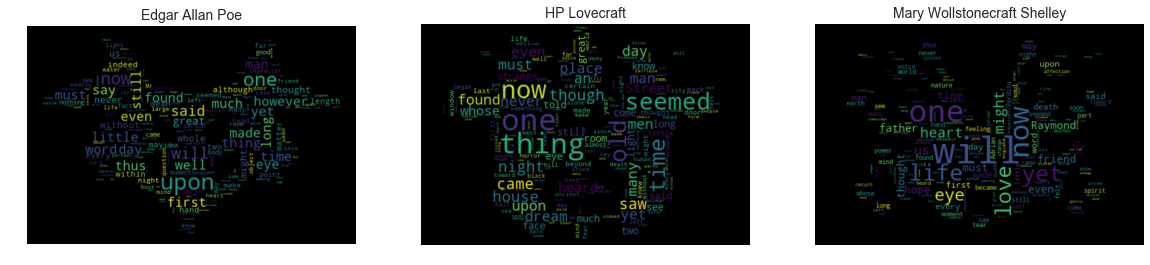

In [94]:
create_wordclouds(STOPWORDS)

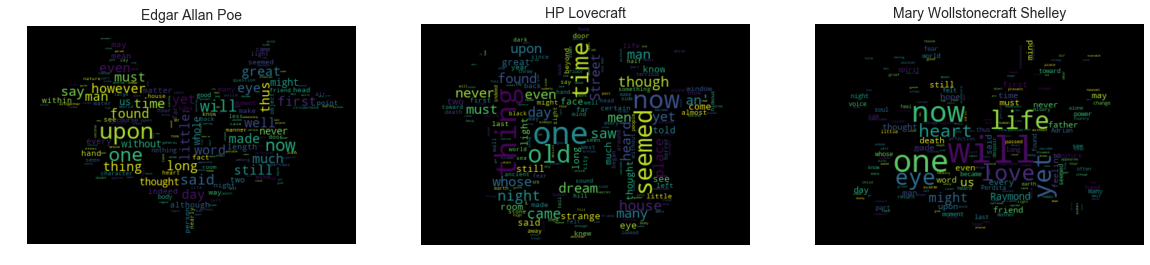

In [95]:
# what if we do include the stopwords?
create_wordclouds(None)

What we see is that there appear to be some differences in terms of the most used words between the writers which is certainly a good news because the basic features like single words (1-grams) or word pairs (2-grams) or other word sequences may have a potential to me meaningful if we include them in our model.

## Words that start with capital letters

What about these words, are there many of them and what are they exactly? This woiuld be interesting to find out as word capitalization is among typical features we might include in our model.

In [96]:
cap_dict = defaultdict(list)  # collect all capitalized words by writer

for r in train_data.iterrows():
    cap_ws = [''.join([c for c in v if c.isalpha()]) 
                  for w in r[1].text.split('.') 
                      for v in w.split()[1:] if v.istitle()] 
    if cap_ws:
        cap_dict[r[1].author].extend(cap_ws)

In [97]:
pd.DataFrame.from_dict({wr_dict[w]: Counter(cap_dict[w]).most_common(20) for w in cap_dict})

,Edgar Allan Poe,HP Lovecraft,Mary Wollstonecraft Shelley
0,"(I, 2902)","(I, 2215)","(I, 3385)"
1,"(Mr, 151)","(Street, 99)","(Raymond, 203)"
2,"(Madame, 67)","(West, 67)","(Perdita, 127)"
3,"(The, 54)","(Arkham, 58)","(Adrian, 105)"
4,"(Dupin, 51)","(Innsmouth, 57)","(England, 88)"
5,"(God, 47)","(Dr, 51)","(Idris, 85)"
6,"(Marie, 44)","(Gilman, 51)","(Windsor, 72)"
7,"(A, 43)","(The, 48)","(London, 68)"
8,"(No, 41)","(Old, 46)","(Elizabeth, 58)"
9,"(M, 40)","(Sir, 40)","(Greece, 42)"


It clearly makes sense add such words to features as these are notably different between the authors (except, of course, the stop words like 'I' or 'The').

## Basic Model

This seem slike the right time to put together a basic model to get a feeling of what sort of scores we can get without making any serious effort.

In [99]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

class FirstWord(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def transform(self, X, **transform_params):
        res = X.apply(lambda _: _.split()[0])
        
        print(res.shape)
        return X.apply(lambda _: _.split()[0]).fillna(0)

    def fit(self, X, y=None, **fit_params):
        return self
    
pipe = Pipeline([
    ('features', FeatureUnion([
        ('stds', Pipeline([('vect', CountVectorizer(analyzer='word', 
                                                    ngram_range=(1, 3), 
                                                    stop_words="english")),
                                  ('tfidf', TfidfTransformer())
                          ]))
     #   ('first_word', FirstWord())
                              ])),
    ('clf', SGDClassifier(max_iter=1000, loss='modified_huber')),
])

parameters = {
    'features__stds__vect__max_df': (0.5, 0.75, 1.0),
    'features__stds__vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet')
}

if __name__ == "__main__":
    
    grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=1)
    t0 = time.time()
    grid_search.fit(train_data['text'], train_data['author'])
    predictions = grid_search.predict_proba(test_data['text'])
    
    print("elapsed time: {:.0f} min {:.0f} sec".format(*divmod(time.time() - t0, 60)))
    print("best score: {:.2f}".format(grid_search.best_score_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 10.0min finished


elapsed time: 10 min 16 sec
best score: 0.81


In [119]:
pdf = pd.concat([test_data.loc[:,'id'], pd.DataFrame(predictions, columns=grid_search.classes_)], axis=1)

In [121]:
pdf.to_csv('sub1.csv', index=False)